In [16]:
import numpy as np
import pandas as pd

def ann_reader(annotation, anntr=None, from_idx=None, to_idx=None):
    """
    Annotation Reader
    -------------------------------------------------------------------------
    This function reads quality annotations from a CSV file for the BUT QDB dataset.

    Args:
        annotation (str): Path to the annotation CSV file (without '.csv' extension).
        anntr (list or np.ndarray, optional): Indices of annotators to use.
        from_idx (int, optional): Start sample index.
        to_idx (int, optional): End sample index.

    Returns:
        np.ndarray: Array of annotations, sample-by-sample.

    Example:
        ann = ann_reader('100001_ANN', [1, 4], 1, 1000000)
    """

    # Read CSV file into numpy array
    TA = pd.read_csv(f"{annotation}.csv").to_numpy()

    sl = np.array([0, 3, 6, 9])  # MATLAB is 1-based, Python is 0-based
    # Find valid columns for annsize
    valid_sl = sl[~np.isnan(TA[-1, sl + 1])]
    annsize = [len(anntr) if anntr is not None else 4, int(TA[-1, valid_sl[-1] + 1]) if valid_sl.size > 0 else TA.shape[1]]

    ann = np.zeros(annsize)

    # Handle default arguments
    if anntr is None:
        anntr = np.arange(4)
    if from_idx is None:
        from_idx = 0
    if to_idx is None:
        to_idx = annsize[1]

    poc = 0
    sl = sl[anntr]
    for i in sl:
        Lan = np.sum(~np.isnan(TA[:, i]))
        poc += 1

        # Find M
        M = None
        for j in range(Lan):
            if TA[j, i] >= from_idx:
                M = j
                break

        # Find N
        N = None
        for j in range(M + 1, Lan):
            if TA[j, i + 1] >= to_idx:
                N = j
                break

        # Fill ann
        for j in range(M, N + 1):
            start = int(TA[j, i])
            end = int(TA[j, i + 1])
            value = TA[j, i + 2]
            ann[poc - 1, start:end + 1] = value

    ann = ann[:, from_idx:to_idx]
    return ann


In [24]:

path_ann = r"D:\Extra datasets\brno-university-of-technology-ecg-quality-database-but-qdb-1.0.0\100001\100001_ANN"

ann = ann_reader(path_ann, [0, 3], 1, 1000000)
print(ann.shape)
print(ann[0, :20])

(2, 999999)
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


In [25]:
def ecg_dataloader(dat_file, dtype=np.float32):
    """
    ECG DataLoader for DAT files.
    ------------------------------------------------------------
    Loads ECG signal data from a .dat file (binary format).

    Args:
        dat_file (str): Path to the .dat file.
        dtype (np.dtype, optional): Data type for the output array.

    Returns:
        np.ndarray: 1D array of ECG samples.
    """
    with open(dat_file, 'rb') as f:
        data = np.fromfile(f, dtype=dtype)
    return data

In [27]:
ecg_raw = ecg_dataloader(r"D:\Extra datasets\brno-university-of-technology-ecg-quality-database-but-qdb-1.0.0\100001\100001_ECG.dat")

In [42]:
with open(r"D:\Extra datasets\brno-university-of-technology-ecg-quality-database-but-qdb-1.0.0\100001\100001_ECG.dat", 'r') as file:
    content = file.read()
    print(content)

UnicodeDecodeError: 'charmap' codec can't decode byte 0x8d in position 20: character maps to <undefined>

In [29]:
print(ecg_raw.shape)
print(ecg_raw[:20])

(43543500,)
[4.7351334e+37 5.2668144e+37 5.0674404e+37 3.4143206e+37 2.6499995e+37
 2.4838359e+37 1.9896082e+37 1.6572961e+37 1.6074442e+37 1.5243695e+37
 1.4080598e+37 1.1920569e+37 1.1588257e+37 9.5325582e+36 7.2894771e+36
 6.9571232e+36 7.4556065e+36 7.5386731e+36 7.7048406e+36 4.1847070e+36]


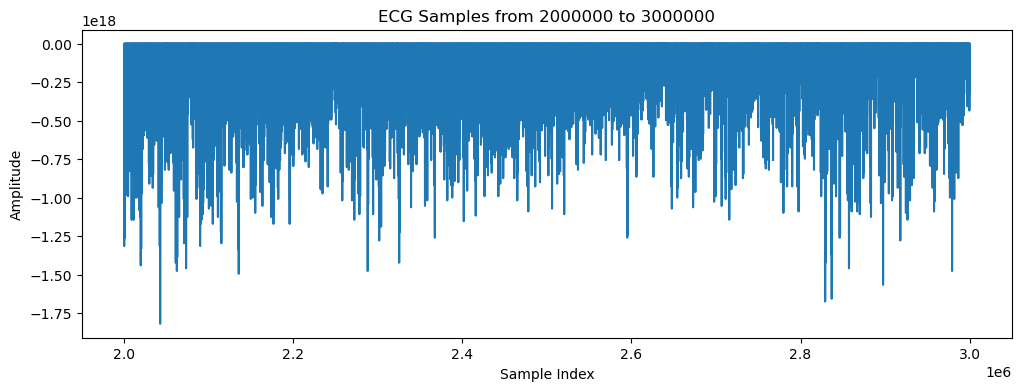

In [39]:
import matplotlib.pyplot as plt

def plot_ecg_window(ecg_data, start=0, end=2000):
    plt.figure(figsize=(12, 4))
    plt.plot(np.arange(start, end), ecg_data[start:end])
    plt.title(f"ECG Samples from {start} to {end}")
    plt.xlabel("Sample Index")
    plt.ylabel("Amplitude")
    plt.show()

# Example usage:
plot_ecg_window(ecg_raw, start=2000000, end=3000000)

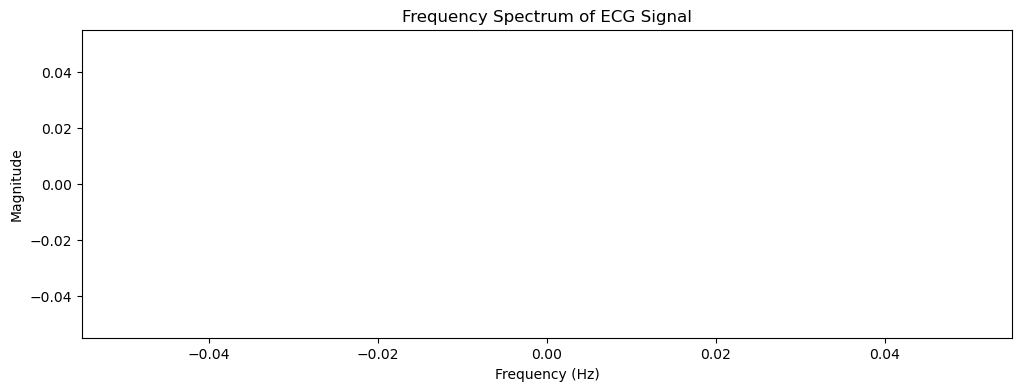

In [41]:
# Frequency analysis using FFT
ecg_fft = np.fft.fft(ecg_raw)
freqs = np.fft.fftfreq(len(ecg_raw), d=1000)  # Assuming sampling rate = 1000 Hz, adjust 'd' as needed

plt.figure(figsize=(12, 4))
plt.plot(freqs[:len(freqs)//2], np.abs(ecg_fft)[:len(ecg_fft)//2])
plt.title("Frequency Spectrum of ECG Signal")
plt.xlabel("Frequency (Hz)")
plt.ylabel("Magnitude")
plt.show()

In [67]:
from pathlib import Path
import numpy as np
import pandas as pd
import wfdb

def load_wfdb_record(basepath):
    """
    Load a WFDB record (.hea + .dat) using wfdb.
    basepath: path WITHOUT extension, e.g. r"...\\100001\\100001"
    Returns: dict with 'signals', 'channel_names', 'fs', 't', 'meta'
    """
    basepath = Path(basepath)
    rec = wfdb.rdrecord(str(basepath))  # wfdb handles .hea/.dat pairing

    # Physical signals in proper units (mV for ECG if header defines it)
    sig = rec.p_signal if rec.p_signal is not None else rec.d_signal.astype(float)
    ch_names = [s.strip() for s in rec.sig_name]
    fs = float(rec.fs)

    # Time axis in seconds
    t = np.arange(sig.shape[0]) / fs

    return {
        "signals": sig,                 # shape (N, C)
        "channel_names": ch_names,      # list of len C
        "fs": fs,
        "t": t,
        "meta": {
            "basepath": str(basepath),
            "units": [getattr(rec, "units", [""] * sig.shape[1])[i] if hasattr(rec, "units") else "" for i in range(sig.shape[1])],
            "comments": getattr(rec, "comments", []),
        }
    }

def split_ecg_and_acc(record_dict):
    """
    Convenience splitter: returns ECG array (N, n_ecg) and ACC dict if present.
    Tries to detect channels by common names.
    """
    sig = record_dict["signals"]
    names = [n.upper() for n in record_dict["channel_names"]]

    # Common labels seen in BUT QDB: ECG, ECG1/2, ACC_X, ACC_Y, ACC_Z
    ecg_idx = [i for i, n in enumerate(names) if ("ECG" in n) or (n in {"I","II","MLII","V1","V2","V3","V4","V5","V6"})]
    acc_map = {axis: next((i for i, n in enumerate(names) if axis in n), None) for axis in ("ACC_X","ACC_Y","ACC_Z")}

    ecg = sig[:, ecg_idx] if ecg_idx else None
    acc = {k: sig[:, idx] for k, idx in acc_map.items() if idx is not None}

    return ecg, acc, ecg_idx, acc_map

from pathlib import Path
import numpy as np
import pandas as pd

def ann_reader_csv_flex(annotation_csv_path, anntr=None, from_idx=None, to_idx=None,
                        include_consensus=True):
    """
    Læser BUT QDBs _ANN.csv (variabelt antal annotatører + optional consensus).
    - annotation_csv_path: fuld sti til ..._ANN.csv ('.csv' må både være med/uden)
    - anntr: hvilke annotatører der ønskes:
        * None  -> alle annotatører (+ consensus hvis include_consensus=True)
        * liste af 1-baserede indekser, fx [1,2,4] (hvor sidste er consensus ved 4 tripler)
        * liste af strings, fx ["consensus"] eller ["ann1","ann3","consensus"]
    - from_idx / to_idx: 1-baserede sample-indekser (inklusiv), som i MATLAB.
      Default: hele længden i filen.
    - include_consensus: hvis anntr=None, skal "consensus" med? (default True)

    Returnerer:
      ann   : (n_selected, L) float array med sample-for-sample labels
      labels: liste med rækkeninge (fx ["ann1","ann2","ann3","consensus"])
    """
    p = Path(str(annotation_csv_path))
    if p.suffix.lower() != ".csv":
        p = p.with_suffix(".csv")

    df = pd.read_csv(p)
    TA = df.to_numpy()

    n_cols = TA.shape[1]
    if n_cols % 3 != 0:
        raise ValueError(f"Forventer kolonner i tripler, men fandt {n_cols} kolonner.")

    # Find tripler (start,slut,værdi) for hver annotatør
    n_triplets = n_cols // 3
    triplet_starts = np.arange(0, 3*n_triplets, 3, dtype=int)   # 0,3,6,...

    # Lav labels: ann1, ann2, ..., og sidste hedder 'consensus'
    labels_all = [f"ann{i+1}" for i in range(n_triplets)]
    if n_triplets >= 1:
        labels_all[-1] = "consensus"

    # Vælg annotatører
    if anntr is None:
        selected_idx = list(range(n_triplets))  # 0-baseret
        if not include_consensus and labels_all[-1] == "consensus":
            selected_idx = selected_idx[:-1]
    else:
        selected_idx = []
        if all(isinstance(x, (int, np.integer)) for x in anntr):
            # 1-baserede indekser ind -> 0-baseret
            for a in anntr:
                if not (1 <= a <= n_triplets):
                    raise ValueError(f"Annotatør-index {a} ligger uden for 1..{n_triplets}.")
                selected_idx.append(a-1)
        else:
            # Strings: map til indekser via labels
            name2idx = {name:i for i, name in enumerate(labels_all)}
            for name in anntr:
                key = str(name).strip().lower()
                if key in {"cons", "consensus"}:
                    key = "consensus"
                if key not in name2idx:
                    raise ValueError(f"Ukendt annotatør '{name}'. Mulige: {labels_all}")
                selected_idx.append(name2idx[key])

    sel_labels = [labels_all[i] for i in selected_idx]

    # Bestem total længde (som i MATLAB: kig på sidste række 'slut'-kolonner)
    last_row = TA[-1, :]
    # Tag max af alle 'slut' kolonner (i+1)
    possible_lengths = []
    for i in triplet_starts:
        end_val = last_row[i+1]
        if not np.isnan(end_val):
            possible_lengths.append(int(end_val))
    total_len = max(possible_lengths) if possible_lengths else TA.shape[1]

    if from_idx is None:
        from_idx = 1
    if to_idx is None:
        to_idx = int(total_len)

    from_idx = int(from_idx)
    to_idx   = int(to_idx)
    if to_idx < from_idx:
        raise ValueError("to_idx skal være >= from_idx")

    out_len = to_idx - from_idx + 1
    ann = np.zeros((len(selected_idx), out_len), dtype=float)

    # Fyld rækkerne én annotatør ad gangen
    for r, ti in enumerate(selected_idx):
        i = triplet_starts[ti]          # kolonne-indeks for denne triplets 'start'
        starts = TA[:, i]
        Lan = int(np.sum(~np.isnan(starts)))
        if Lan == 0:
            continue

        # Find første segment M med start >= from_idx
        M = None
        for j in range(Lan):
            if TA[j, i] >= from_idx:
                M = j
                break
        if M is None:
            # alle segmenter slutter før fra-vinduet -> intet at fylde
            continue

        # Find sidste segment N hvor 'slut' når forbi to_idx
        N = None
        for j in range(M+1, Lan):
            if TA[j, i+1] >= to_idx:
                N = j
                break
        if N is None:
            N = Lan - 1

        # Udfyld sample-for-sample
        for j in range(M, N+1):
            start = int(TA[j, i])
            end   = int(TA[j, i+1])     # inklusiv
            value = TA[j, i+2]
            s = max(start, from_idx)
            e = min(end,   to_idx)
            if s <= e:
                ann[r, (s - from_idx):(e - from_idx + 1)] = value

    return ann, sel_labels

def ann_reader_csv_flex_robust(annotation_csv_path,
                               anntr=None,
                               from_idx=None,
                               to_idx=None,
                               include_consensus=True,
                               dtype=np.uint8):
    """
    Læs BUT QDB _ANN.csv (3 annotatører + consensus) og returnér sample-for-sample labels.
    - anntr: None => alle (inkl. consensus hvis include_consensus=True)
             1-baserede indekser (fx [1,2,3,4]) ELLER navne ["ann1","ann3","consensus"]
    - from_idx / to_idx: 1-baserede inklusive grænser (som i MATLAB). Default = hele længden.
    - dtype: np.uint8 anbefales (fylder 1 byte pr. sample)
    Returnerer: ann (rækker = valgte annotatører, kolonner = samples), labels (liste)
    """
    p = Path(str(annotation_csv_path))
    if p.suffix.lower() != ".csv":
        p = p.with_suffix(".csv")

    # 1) Læs CSV robust (auto-delimiter) og tvangskonverter til tal
    df = pd.read_csv(p, sep=None, engine="python")
    for c in df.columns:
        df[c] = pd.to_numeric(df[c], errors="coerce")
    TA = df.to_numpy()

    n_cols = TA.shape[1]
    if n_cols % 3 != 0:
        raise ValueError(f"Forventer kolonner i tripler (start,slut,værdi). Fandt {n_cols} kolonner.")

    # 2) Tripler + labels (sidste triple = 'consensus')
    n_triplets = n_cols // 3
    triplet_starts = np.arange(0, 3*n_triplets, 3, dtype=int)
    labels_all = [f"ann{i+1}" for i in range(n_triplets)]
    if n_triplets >= 1:
        labels_all[-1] = "consensus"

    # 3) Vælg annotatører
    if anntr is None:
        selected_idx = list(range(n_triplets))
        if not include_consensus and labels_all[-1] == "consensus":
            selected_idx = selected_idx[:-1]
    else:
        selected_idx = []
        if all(isinstance(x, (int, np.integer)) for x in anntr):
            for a in anntr:
                if not (1 <= a <= n_triplets):
                    raise ValueError(f"Annotatør-index {a} udenfor 1..{n_triplets}.")
                selected_idx.append(a-1)
        else:
            name2idx = {name:i for i, name in enumerate(labels_all)}
            for name in anntr:
                key = str(name).strip().lower()
                if key in {"cons", "consensus"}:
                    key = "consensus"
                if key not in name2idx:
                    raise ValueError(f"Ukendt annotatør '{name}'. Mulige: {labels_all}")
                selected_idx.append(name2idx[key])

    sel_labels = [labels_all[i] for i in selected_idx]

    # 4) Bestem total længde fra 'slut'-kolonner (maks gyldig slut)
    last_row = TA[-1, :]
    possible_lengths = []
    for i in triplet_starts:
        end_val = last_row[i+1]
        if not np.isnan(end_val):
            possible_lengths.append(int(end_val))
    total_len = max(possible_lengths) if possible_lengths else TA.shape[0]

    # Default interval
    if from_idx is None:
        from_idx = 1
    if to_idx is None:
        to_idx = int(total_len)

    from_idx = int(from_idx)
    to_idx = int(to_idx)
    if to_idx < from_idx:
        raise ValueError("to_idx skal være >= from_idx")

    out_len = to_idx - from_idx + 1
    ann = np.zeros((len(selected_idx), out_len), dtype=dtype)

    # 5) Udfyld rækker – robust valg af M/N (tager højde for segment der starter før from_idx)
    for r, ti in enumerate(selected_idx):
        i = triplet_starts[ti]
        starts = TA[:, i]
        ends   = TA[:, i+1]
        vals   = TA[:, i+2]

        valid = (~np.isnan(starts)) & (~np.isnan(ends))
        idxs  = np.flatnonzero(valid)
        if idxs.size == 0:
            continue

        # MATLAB-agtig M: første med start >= from_idx
        M_candidates = idxs[starts[idxs] >= from_idx]
        if M_candidates.size > 0:
            M = int(M_candidates[0])
        else:
            # Fallback: hvis ingen start >= from_idx, men et segment dækker from_idx (end >= from_idx)
            cover = idxs[ends[idxs] >= from_idx]
            M = int(cover[0]) if cover.size > 0 else None

        if M is None:
            # intet segment berører vinduet
            continue

        # MATLAB-agtig N: første med end >= to_idx
        N_candidates = idxs[(idxs >= M) & (ends[idxs] >= to_idx)]
        if N_candidates.size > 0:
            N = int(N_candidates[0])
        else:
            # Fallback: sidste der starter før to_idx
            before_to = idxs[(idxs >= M) & (starts[idxs] <= to_idx)]
            if before_to.size == 0:
                continue
            N = int(before_to[-1])

        # Fyld sample-for-sample (inklusive ender)
        for j in range(M, N+1):
            start = int(starts[j])
            end   = int(ends[j])
            value = vals[j]
            if np.isnan(value):
                continue
            s = max(start, from_idx)
            e = min(end,   to_idx)
            if s <= e:
                ann[r, (s - from_idx):(e - from_idx + 1)] = int(value)

    return ann, sel_labels

# ------------ Example usage ------------
# base = r"D:\Extra datasets\brno-university-of-technology-ecg-quality-database-but-qdb-1.0.0\100001\100001"
# rec = load_wfdb_record(base)
# ecg, acc, ecg_idx, acc_map = split_ecg_and_acc(rec)
# ann = ann_reader_csv(base + "_ANN.csv", anntr=[1,4], from_idx=1, to_idx=1000000)

# Quick sanity check: print what we loaded
# print(rec["channel_names"], rec["fs"], ecg.shape if ecg is not None else None, list(acc.keys()))


In [ ]:
base_path = r"D:\Extra datasets\brno-university-of-technology-ecg-quality-database-but-qdb-1.0.0\100001\100001"
ecg_path = base_path + r"_ECG"
rec = load_wfdb_record(ecg_path)
ecg, acc, ecg_idx, acc_map = split_ecg_and_acc(rec)
# ann = ann_reader_csv(base_path + "_ANN.csv", anntr=[1,4], from_idx=1, to_idx=1000000)

print(rec["channel_names"], rec["fs"], ecg.shape if ecg is not None else None, list(acc.keys()))

# 1) Alle annotatører inkl. consensus, hele længden
ann_all, labels = ann_reader_csv_flex(base_path + "_ANN.csv")
print(ann_all.shape, labels)  # fx (4, L) og ["ann1","ann2","ann3","consensus"]

# # 2) Kun de 3 menneskelige annotatører, samples 1..1,000,000
# ann_3, labels3 = ann_reader_csv_flex(csv_path, anntr=[1,2,3], from_idx=1, to_idx=1_000_000)
# print(ann_3.shape, labels3)   # (3, 1000000)

# # 3) Kun consensus via navn
# ann_cons, labc = ann_reader_csv_flex(csv_path, anntr=["consensus"], from_idx=1000, to_idx=200000)
# print(ann_cons.shape, labc)   # (1, 199001), ["consensus"]

# Læs EKG (WFDB)
# base = r"...\100001\100001"   # uden .dat/.hea
# rec = load_wfdb_record(base)
# N = rec["signals"].shape[0]


['ECG'] 1000.0 (87087000, 1) []
(4, 87087000) ['ann1', 'ann2', 'ann3', 'consensus']


In [69]:
ann, labels = ann_reader_csv_flex_robust(base_path + "_ANN.csv", anntr=['ann1', 'ann2', 'ann3',"consensus"],
                                         from_idx=1, to_idx=rec["signals"].shape[0])   # N fra EKG
print(ann.shape, labels)
print("Ikke-nul pr. spor:", [int(np.count_nonzero(ann[k])) for k in range(ann.shape[0])])



(4, 87087000) ['ann1', 'ann2', 'ann3', 'consensus']
Ikke-nul pr. spor: [86888133, 87067475, 87079953, 87079953]


In [75]:
# Se de første 10 gyldige rækker for fx consensus (sidste triple)
import pandas as pd
raw = pd.read_csv(base_path + "_ANN.csv", sep=None, engine="python")
for c in raw.columns: raw[c] = pd.to_numeric(raw[c], errors="coerce")

starts = raw.iloc[:, 9]   # 10.,11.,12. kolonne = consensus (0-baseret: 9,10,11)
ends   = raw.iloc[:,10]
vals   = raw.iloc[:,11]
mask = (~starts.isna()) & (~ends.isna())
print(raw.loc[mask, [raw.columns[9], raw.columns[10], raw.columns[11]]].head(10))

ann_consensus = raw.loc[mask, [raw.columns[9], raw.columns[10], raw.columns[11]]]


         1.4     7047.1  2.2
0     7048.0    17209.0  1.0
1    17210.0    28694.0  2.0
2    28695.0    32653.0  1.0
3    32654.0   112474.0  2.0
4   112475.0   174872.0  1.0
5   174873.0   192330.0  2.0
6   192331.0  1163574.0  1.0
7  1163575.0  1165034.0  2.0
8  1165035.0  2197584.0  1.0
9  2197585.0  2322254.0  2.0


In [77]:
print(ann_consensus)

            1.4      7047.1  2.2
0        7048.0     17209.0  1.0
1       17210.0     28694.0  2.0
2       28695.0     32653.0  1.0
3       32654.0    112474.0  2.0
4      112475.0    174872.0  1.0
..          ...         ...  ...
757  86486096.0  86580752.0  2.0
758  86580753.0  86588415.0  1.0
759  86588416.0  86757975.0  2.0
760  86757976.0  86827127.0  1.0
761  86827128.0  87087000.0  2.0

[762 rows x 3 columns]


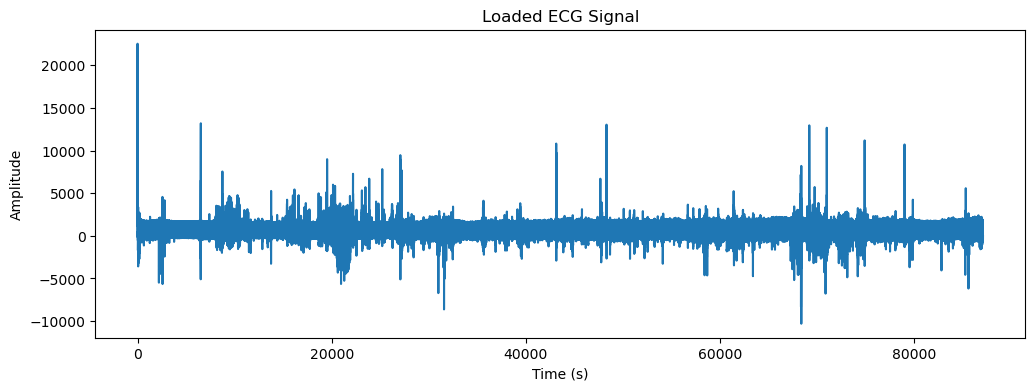

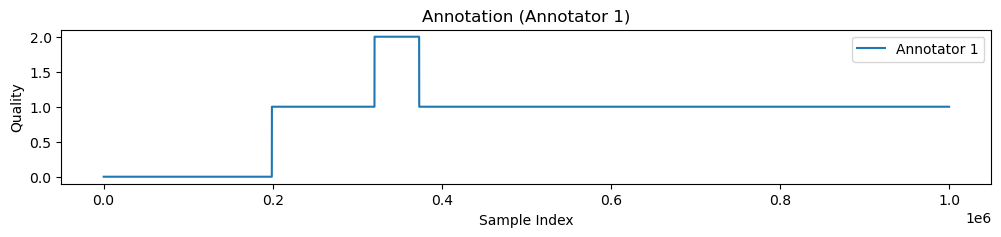

In [49]:
import matplotlib.pyplot as plt

# Plot ECG signal
plt.figure(figsize=(12, 4))
plt.plot(rec["t"], ecg)
plt.title("Loaded ECG Signal")
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.show()

# Plot annotation for first annotator
plt.figure(figsize=(12, 2))
plt.plot(np.arange(ann.shape[1]), ann[0], label="Annotator 1")
plt.title("Annotation (Annotator 1)")
plt.xlabel("Sample Index")
plt.ylabel("Quality")
plt.legend()
plt.show()

In [50]:
ann.shape

(2, 1000000)